In [1]:
import pandas as pd
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#function to determine where the closest field_putout would be, which is why our SS decided to go for putout play
#plug-in coordinates, it determines the distance of 2 closest preidentified points for our SS to tag for an out
def closest_tag(x): 
    
    min_dist = []
    possible_options = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
    for i in possible_options:
        min_dist.append(np.linalg.norm(x-field_coord[i]))
    
    min_dist = sorted(min_dist)
    
    return sum(min_dist[0:2]) / 2
    
#this function will calculate the prbability between the hitter vs. our SS
def fieldvsbatt(x1,x2):
    
    u = x1-x2
    
    return norm.cdf(u/ (0.25*math.sqrt(2)))


#this function returns the potential bounce velocity of the ball
def bounce_velo(ev):
    ev_ft = 1.46667 * ev
    V = ev_ft * 0.546
    return V


def bounce_distance(ev):
    
    ev_ft = 1.46667 * ev
    deg = 30 * math.pi / 180
    V = ev_ft * 0.546 #coefficient of restititution of a baseball
    Vy = ev_ft * math.sin(deg)
    Vx = ev_ft * math.cos(deg)
    
    return (2 * Vx * Vy) / 32.1741 #returns the measurement in ft
    
#this function will be used to calculate the new coordinate of our player based off the hang_time
def new_coord(a,b,d2): #include points a and b as a np.array((x,y)), a & b are two points
    d = np.linalg.norm(a-b)
    c_x = a[0] - (d2*(a[0]-b[1]))/d
    c_y = a[1] - (d2*(a[1]-b[1]))/d
    return np.array((c_x,c_y))



In [3]:
#read our dataset into pandas dataframe
df = pd.read_excel('shortstopdefense.xlsx')

In [4]:
#data cleaning
#check for NA or null Values

df.isnull().sum().sum()

#there is let's drop them. Can't find anything if there's no data.
df = df.dropna()
df = df.reset_index()

In [5]:
#look only at the ones fielded by the SS, since we're only looking at SS leaderboard
df = df[df['fielded_pos']==6]
df = df.reset_index()

In [6]:
#combine the coordiantes to a column itself, so we can use numpy's distance formula for faster calculation

df['ball_land_coord']=list(zip(df['landing_location_x'], df['landing_location_y']))
df['player_coord']=list(zip(df['player_x'], df['player_y']))

In [7]:
#Set the bases, and plates in coordinates, 1-Pithcer, 2-Home, 3-1st base, 4-2nd base, 5- 3rd base, 6-SS
#this will come handy when we start calculating the distance and opportunity
#since there's not one exact spot of SS coordiantes, we'll use the average of where they usually stand (ie. mean)
#take the mid point from 2nd base to 3rd base as my coord for where my SS throws to 6th posistion (either 3rd base/pitcher covering)
#we're going to also include midpoints to consider when the SS can tag the person out, or run to the nearby base whichever
#is closer would be used

second_base_coord = 127.28125 #127 3,3/8 inches
pos_6 = [np.average(df['player_x']), np.average(df['player_y'])] #take the average posistion of where most SS usually stands
field_coord = {1: [0,60.5], 2: [0,0], 2.5: [second_base_coord/4, second_base_coord/4],
               3:[second_base_coord/2, second_base_coord/2], 
               3.5: [(0+second_base_coord/2)/2, (second_base_coord+second_base_coord/2)/2], 
               4: [0, second_base_coord], 4.5: [(0-second_base_coord/2)/2, (second_base_coord+second_base_coord/2)/2],
               5: [-second_base_coord/2, second_base_coord/2], 5.5 : [-second_base_coord/4, second_base_coord/4],
               6: pos_6 }

In [8]:
#we need to dissect fielding_play to
#this will be used to calculate the receiving end of our shortstop throw if he has any
df['fieldingplay'] = df['fieldingplay'].astype(int)
df['fieldingplay'] = df['fieldingplay'].astype(str)

#create a list of the plays segrated by the integer, this way we can see where the SS is throwing the ball to.
list_test = []
for i in df['fieldingplay']:
    list_test.append([int(d) for d in i])
    
df['field_play'] = list_test


#the receiving end of SS fielded ball
pos_passed = []
for i in range(len(df)):
    if len(df['field_play'][i]) == 1:
        pos_passed.append(int(df['fielded_pos'][i]))
    else:
        pos_passed.append(int(df['field_play'][i][1]))

df['ball_passed'] = pos_passed


In [9]:
#calculate distance from player and first bounce
df['player_ball_first_landed'] =np.sqrt((df['player_x'] - df['landing_location_x'])**2 + (df['player_y'] - df['landing_location_y'])**2) 

#bounce distance uses exit velocity and EOR to estimate the distance it can travel
bounce_dist = []

for i in range(len(df)):
    bounce_dist.append(bounce_distance(df['launch_speed'][i])) #here we recall the function that we created earlier
    
df['bounce_distance'] = bounce_dist

In [31]:
#incorproate hangtime to better detrmine intercept point
distance_between_hang = []

#the player travlled how much distance
df['hang_time_travel'] = df['hang_time'] * 27

player_new_coord = []
player_catch = [] #determine if the player has caught the ball
player_new_distance = []

#find the new coordiantes, 
for i in range(len(df)):
    a = np.array(df['player_coord'][i])
    b = np.array(df['ball_land_coord'][i])
    c = new_coord(a,b,df['hang_time_travel'][i]) #the potential coordinate of where the fielder ran to
    
    if df['hang_time_travel'][i] >= df['player_ball_first_landed'][i] : #player had enough time to cover the distance before ball landed
        player_new_coord.append(b) #therefore he cuaght the ball, and this would be used as his intercept_point
        player_catch.append(True)
        player_new_distance.append(0) #therefore his distance is 0 from the ball
    else:
        player_new_coord.append(c)
        player_catch.append(False)
        player_new_distance.append(np.linalg.norm(c-b))
        
df['player_new_coord'] = player_new_coord
df['player_catch'] = player_catch #boolean that tells us if the ball was caught, therefore intercept-time = hang_time
df['player_new_distance'] = player_new_distance

In [43]:
#intercept point, if the bounce distance is further than our current SS, we assume the midway point is our intercept coordinate
#finding our intercept coordiantes

intercept_coord = []
#player_x_intercept = []
#player_y_intercept = []
df['player_x_intercept'] = bounce_dist
df['player_y_intercept'] = bounce_dist
for i in range(len(df)):
    
    a = np.array(df['player_new_coord'][i])
    b = np.array(df['ball_land_coord'][i])
    
    if df['player_catch'][i] == True: #if it catch, then intercept point is just where the ball landed
        intercept_coord.append(df['ball_land_coord'][i])
    
    elif df['bounce_distance'][i] >= df['player_new_distance'][i]: #if ball bounces further than where we're at,
        #we'll take the midpoint as the intercept
        df['player_x_intercept'][i] = (df['player_new_coord'][i][0]+df['landing_location_x'][i])/ 2
        df['player_y_intercept'][i] = (df['player_new_coord'][i][1]+df['landing_location_y'][i])/ 2
        intercept_coord.append((df['player_x_intercept'][i],df['player_y_intercept'][i]))
        
    else:
        
        #here we need assume the bounce shall continue, and add it the inital landing spot 
        intercept_coord.append(new_coord(a,b,df['bounce_distance'][i]))
        
#our new intercept coord
df['intercept_coord'] = intercept_coord


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
#Intercept Model
#we are trying to find the distance between our fielder to intercept, and determine the time
#our fielder to reach there, given the hang_time

#find opportuntity distance
opportunity_dist = []
intercept_home = []
for i in range(len(df)):
    
    a = np.array(df['player_new_coord'][i])
    b = np.array(df['intercept_coord'][i])
    
    opportunity_dist.append(np.linalg.norm(a-b)) #where player meets the intercept point
                            
df['opportunity_distance'] = opportunity_dist
                            
#df['intercept_home'] = intercept_home
df['opportunity_time'] = df['hang_time'] + df['opportunity_distance']/ 27

In [60]:
#here we are calculating the distance of the ball to be thrown, or putout
#and the time it requires.
#assume: batter run-speed is 27 fps, throwing speed of our SS on avg is 132 fps
#you need 3/4 of a second to throw the ball

#SS time remaining
play_distance = []
play_time = []

for i in range(len(df)):
    #if df['ball_passed'][i] > 6:
    ##default play is to first base, for an forceplay
    #play_distance.append(np.linalg.norm(np.array(df['ball_land_coord'][i])-field_coord[3]))
    a = np.array(df['intercept_coord'][i])
    
    if df['ball_passed'][i] < 6 and df['ball_passed'][i] != 3:
        play_distance.append(np.linalg.norm(np.array(df['ball_land_coord'][i])-field_coord[df['ball_passed'][i]])) 
        play_time.append(play_distance[i]/ 132 + 0.75)
    
    elif df['ball_passed'][i] == 6 and df['fielded_scoring'][i] == 'f_putout':
        #distance = closest_tag(df['ball_land_coord'][i])
        play_distance.append(closest_tag(a))
        play_time.append(play_distance[i]/27)
    
    else:
        ##default play is to first base, for a forceplay
        play_distance.append(np.linalg.norm(np.array(df['ball_land_coord'][i])-field_coord[3])) 
        play_time.append(play_distance[i]/132 +0.75)
        
df['play_distance'] = play_distance
df['play_time'] = play_time

In [61]:
##Runner time remaining
df['runner_time'] = 90/ 27 - df['opportunity_time']

In [62]:
fieldvsbatt(df['play_time'][0],df['runner_time'][0])

0.9887348147356712

In [63]:
#using our predefined function, we can compare the distributions

OAA_odds = []

for i in range(len(df)):
    
    if df['fielded_scoring'][i] == 'f_putout' or df['fielded_scoring'][i] == 'f_assist':
        OAA_odds.append(fieldvsbatt(df['runner_time'][i],df['play_time'][i] * 1 * 0.975))
    else:
        OAA_odds.append((1-(fieldvsbatt(df['runner_time'][i],df['play_time'][i] * 1 * 0.975)))*-1)

df['OAA'] = OAA_odds

In [65]:
#let's get the aggreagate of our leaderboard
df['opportunity'] = 1
df_pivot = df.pivot_table(index='playerid', values=['opportunity', 'OAA'], aggfunc='sum')
#sort our value
result = df_pivot.sort_values(('OAA'), ascending=False).round()

In [66]:
result

,OAA,opportunity
playerid,,
162393,29.0,148
162648,22.0,145
147431,22.0,154
2950,21.0,118
162066,20.0,176
...,...,...
7654,-1.0,4
189664,-1.0,72
171819,-1.0,12


In [67]:
#export our results
result.to_csv('output.csv')

In [68]:
df.to_excel('out_data.xlsx')

In [76]:
field_coord

{1: [0, 60.5],
 2: [0, 0],
 2.5: [31.8203125, 31.8203125],
 3: [63.640625, 63.640625],
 3.5: [31.8203125, 95.4609375],
 4: [0, 127.28125],
 4.5: [-31.8203125, 95.4609375],
 5: [-63.640625, 63.640625],
 5.5: [-31.8203125, 31.8203125],
 6: [-33.035291167549246, 141.01140661724213]}

In [77]:
bunt = df[df['is_bunt']==True]

int_x = []
int_y = []

for i in range(len(df)):
    int_x.append(df['intercept_coord'][i][0])
    int_y.append(df['intercept_coord'][i][1])

    
base_x = []
base_y = []

for i in [2,3,4,5,1]:
    base_x.append(field_coord[i][0])
    base_y.append(field_coord[i][1])

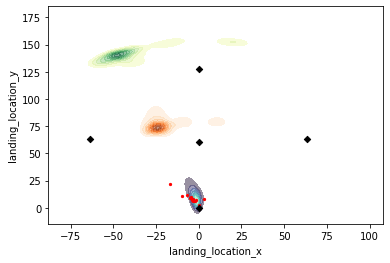

In [78]:
#x1,y1 = np.random.normal(loc=0.0, scale=1.0, size=(100,)), np.random.normal(loc=2.0, scale=1.0, size=(100,))
#x2,y2 = np.random.normal(loc=2., scale=1.0, size=(100,)), np.random.normal(loc=0.0, scale=1.0, size=(100,))

fig, ax = plt.subplots()
fig_dims = (500, 600)
sns.kdeplot(df['player_x'],df['player_y'], shade=True, shade_lowest=False, alpha=0.5, cbar=False, ax=ax, cmap="YlGn")
sns.kdeplot(int_x,int_y, shade=True, shade_lowest=False, alpha=0.5, cbar=False, ax=ax, cmap="Oranges")
sns.kdeplot(df['landing_location_x'],df['landing_location_y'], shade=True, shade_lowest=False, alpha=0.5, cbar=False, ax=ax, cmap="mako")
ax.scatter(bunt['landing_location_x'],bunt['landing_location_y'], color="red", s=5)
#ax.scatter(df['landing_location_x'],df['landing_location_y'], color="blue", s=5)
ax.scatter(base_x,base_y, color="black", s=20, marker='D')
#ax.scatter(df['landing_location_x'],df['landing_location_y'], color="red", s=5)
plt.show()
#ax.scatter(x2,y2, color="C1")

No handles with labels found to put in legend.


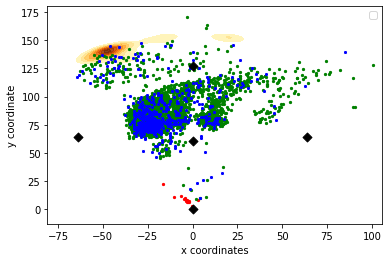

In [125]:
#just a heatmap and scatter plot of where our SS catches were


fig, ax = plt.subplots()
fig_dims = (500, 500)
sns.kdeplot(df['player_x'],df['player_y'], shade=True, shade_lowest=False, alpha=0.9, cbar=False, ax=ax, cmap="YlOrBr")
#sns.kdeplot(int_x,int_y, shade=True, shade_lowest=False, alpha=0.5, cbar=False, ax=ax, cmap="Oranges")
#sns.kdeplot(df['landing_location_x'],df['landing_location_y'], shade=True, shade_lowest=False, alpha=0.5, cbar=False, ax=ax, cmap="mako")
ax.scatter(bunt['landing_location_x'],bunt['landing_location_y'], color="red", s=5)
ax.scatter(df[df['filter']==1]['int_x'],df[df['filter']==1]['int_y'],color="g",marker = 'o', s=5)
ax.scatter(df[df['filter']==0]['int_x'],df[df['filter']==0]['int_y'],color="b",marker='x', s=5)
#ax.scatter(df['landing_location_x'],df['landing_location_y'], color="blue", s=5)
ax.scatter(base_x,base_y, color="black", s=40, marker='D')
plt.legend()
plt.xlabel('x coordinates')
plt.ylabel('y coordinate')
#plt.plot([0, -75], [0,73], 'k-')
#plt.plot([0, 75], [0,73], 'k-')
#ax.scatter(df['landing_location_x'],df['landing_location_y'], color="red", s=5)
plt.savefig('visual.png', bbox_inches='tight', dpi=500)
plt.show()
#plt.savefig('visual.png', bbox_inches='tight')
#ax.scatter(x2,y2, color="C1")

In [82]:
df['intercept_coord']

0         (-16.48510266648072, 74.76567136173855)
1         (-25.32137801005859, 73.69131028235422)
2         (-23.45501116419984, 87.76117032403721)
3        (-31.686532465234066, 82.07090527938193)
4         (-25.73522977876919, 78.87751676085736)
                          ...                    
4716     (-26.528433812400667, 86.58966144283444)
4717     (-13.838338156319196, 74.08779956827132)
4718     (-25.008806403208013, 71.40939401357383)
4719     (-30.804368202847773, 82.66956573024969)
4720    (-14.312948637999742, 100.96767312626602)
Name: intercept_coord, Length: 4721, dtype: object

In [83]:
#splitting our intercept point coordinate

int_x = []
int_y = []

for i in range(len(df)):
    int_x.append(df['intercept_coord'][i][0])
    int_y.append(df['intercept_coord'][i][1])
    
df['int_x'] = int_x
df['int_y'] = int_y

In [88]:
res = []
for i in range(len(df)):
    if df['fielded_scoring'][i] == 'f_putout' or df['fielded_scoring'][i] == 'f_assist':
        res.append(1)
    else:
        res.append(0)

In [90]:
df['filter'] = res

In [92]:
df[df['filter']==1]['int_x']

0      -16.485103
2      -23.455011
3      -31.686532
4      -25.735230
5       -4.452369
          ...    
4714   -25.256887
4715    17.117707
4717   -13.838338
4718   -25.008806
4720   -14.312949
Name: int_x, Length: 4110, dtype: float64